# Dermatoscopic images blur analysis
To estimate the blur we will use the simplest approach - laplacian operator, which normally determines edges in an image. By looking at the variance of of the result we can estimate the detalization of the image. However in the case of skin images it might me quite challenging, especially with low resolution images..

In [15]:
!pip install simplejpeg 

In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
from IPython.display import display_html
from PIL import Image
import gc
import cv2
import simplejpeg 
from tqdm import tqdm

In [17]:
# Directory
directory = '../input/siim-isic-melanoma-classification'
IMAGE_PATH = "../input/siim-isic-melanoma-classification/"

# Import the 2 csv s
train_df = pd.read_csv(directory + '/train.csv')
test_df = pd.read_csv(directory + '/test.csv')

print('Train has {:,} rows and Test has {:,} rows.'.format(len(train_df), len(test_df)))

img_dir = IMAGE_PATH+'/jpeg/train'

Train has 33,126 rows and Test has 10,982 rows.


In [18]:
benign = train_df[train_df['benign_malignant']=='benign']
malignant = train_df[train_df['benign_malignant']=='malignant']

In [19]:
random9_mal = [np.random.choice(malignant['image_name'].values+'.jpg') for i in range(9)]
random9_ben = [np.random.choice(benign['image_name'].values+'.jpg') for i in range(9)]

In [20]:
def crop(img_name):
    with open(img_name, 'rb') as f:
        tf = f.read() # Read whole file in the file_content string
        if simplejpeg.is_jpeg(tf):
            img = simplejpeg.decode_jpeg(tf, colorspace = 'rgb')

    h, w, _ = img.shape
    min_d = min(h, w)
    crop_d = ((max(h, w) - min_d) /2)
    x1 = 0; y1 = 0
    x2 = w; y2 = h
    if h > w:
        y1 = int(crop_d); y2 = int(h - crop_d) 
    else:
        x1 = int(crop_d); x2 = int(w - crop_d)
        
    if min_d > 1024:
        interpolation = cv2.INTER_AREA 
    else:
        interpolation = cv2.INTER_CUBIC
        # interpolation = cv2.INTER_LINEAR 
        
    resized = cv2.resize(img[y1:y2, x1:x2], (1024, 1024), interpolation = interpolation)
    return resized

In [21]:
def variance_of_laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def laplacian(image):
# compute the Laplacian of the image and then return the focus
# measure, which is simply the variance of the Laplacian
    res = cv2.Laplacian(image, cv2.CV_64F)
    lap_var = res.var()
    return res, lap_var

In [22]:
# show 9 images with Blur Index in 3*3 grid
def show9(images, l_type):
    print(f'Display {l_type} Images')
    plt.figure(figsize=(10,8))
    # Iterate and plot random images
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        img = crop(os.path.join(img_dir, images[i]))
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        fm = variance_of_laplacian(gray)
        plt.title(f'Sharpness index : {fm:.2f}')
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    # Adjust subplot parameters to give specified padding
    plt.tight_layout()

Lets look at 9 random benign images and estimate their bluriness

Display benign Images


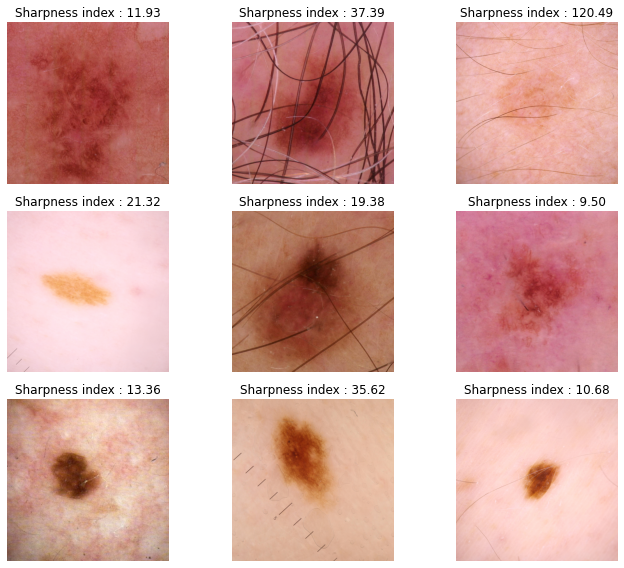

In [23]:
show9(random9_ben, 'benign')

And now lets look at 9 random malignant leisions images and estimate their bluriness

Display malignant Images


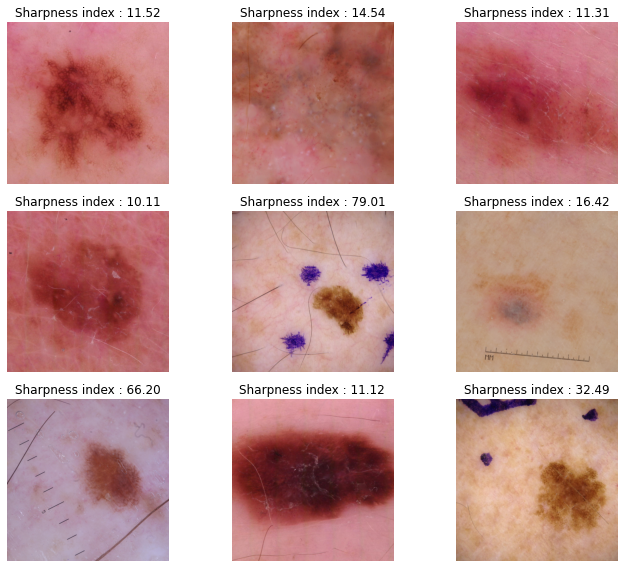

In [24]:
show9(random9_mal, 'malignant')

In [25]:
def show9_RGB(images, l_type):
    print(f'Display {l_type} Images')
    N_subplots = 6
    color = ('b','g','r')

    # Iterate and plot random images
    for i in range(9):
        fig = plt.figure()
        fig.set_figwidth(20)
        fig.set_figheight(3)
        img = crop(os.path.join(img_dir, images[i]))
        ax = fig.add_subplot(1, N_subplots, 1)
        imgplot = plt.imshow(img)
        ax.set_title(f'Size: {img.shape}')
        plt.axis('off')

        for i,col in enumerate(color):
            ax = fig.add_subplot(1, N_subplots, i+2)
            imgplot = plt.imshow(img[:,:,i], cmap='gray')
            ax.set_title(col)
            plt.axis('off')

        color = ('b','g','r')
        ax = fig.add_subplot(1, N_subplots, 5)
        for i,col in enumerate(color):
            histr = cv2.calcHist([img],[i],None,[256],[0,255]) #excluding pure white 255 pixels of the borders in the images
            plt.plot(histr,color = col)
            plt.xlim([0,256])

        ax = fig.add_subplot(1, N_subplots, 6)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mat, fm = laplacian(gray)
        ax.set_title(f'Sharpness index : {fm:.2f}')
        plt.hist(mat.ravel(), bins=100) 
        plt.show()

And now we'll analyze these images by separate channels and plot the histograms

Display Malignant Images


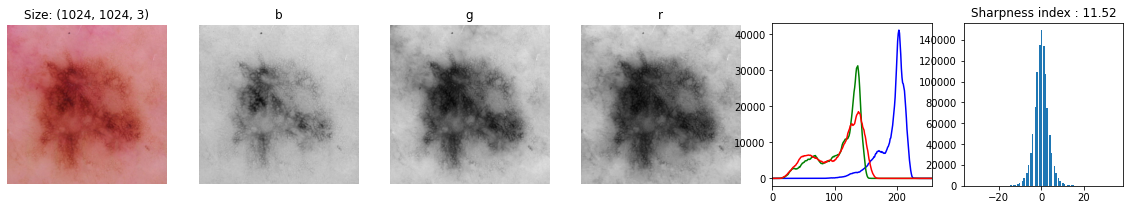

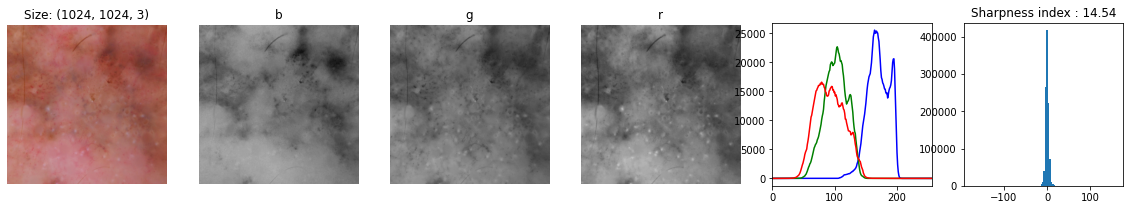

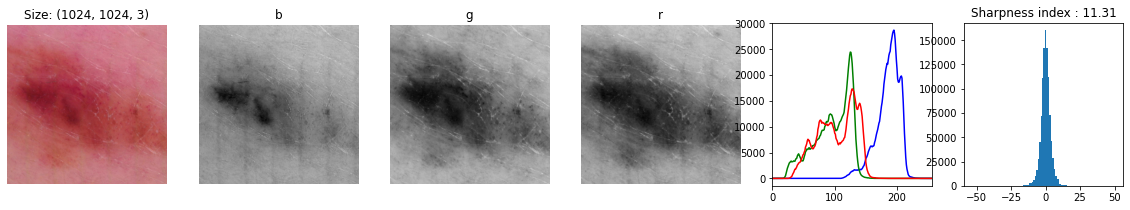

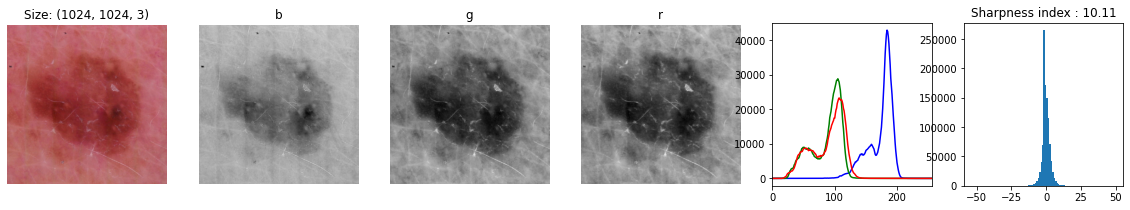

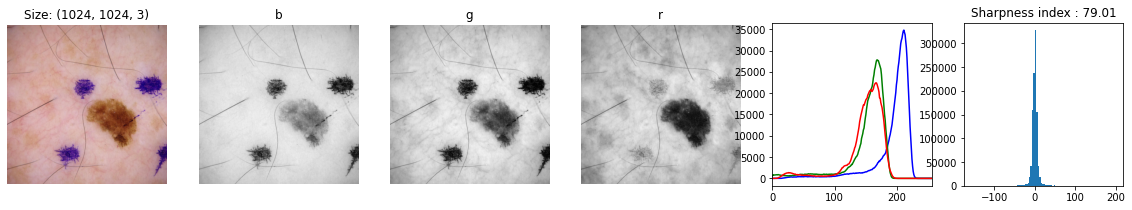

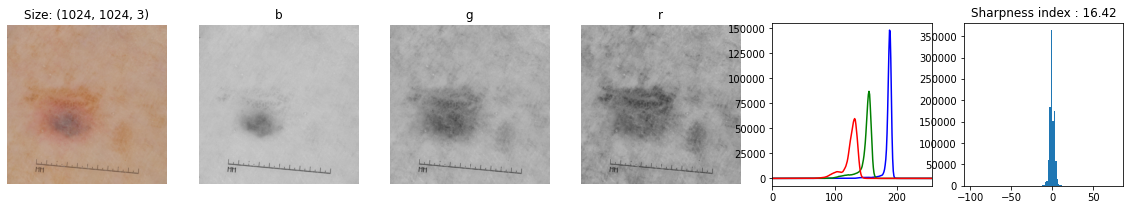

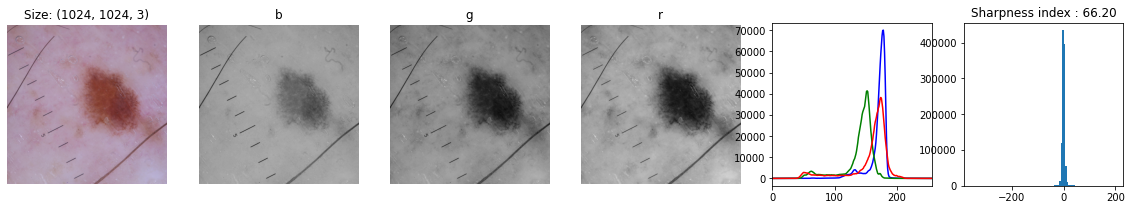

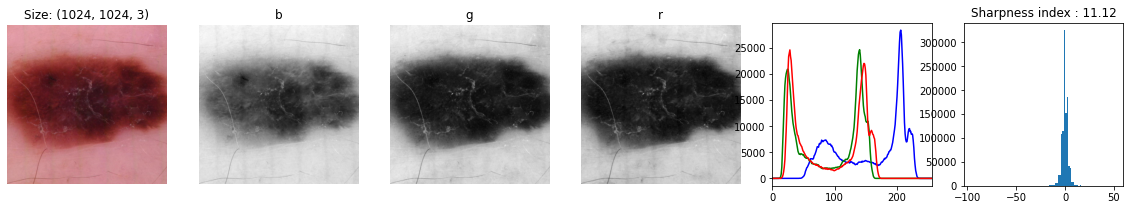

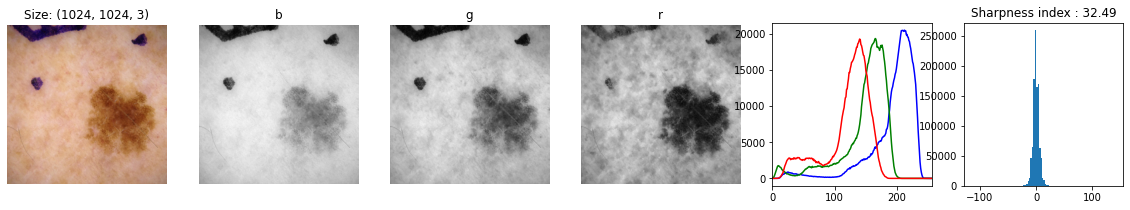

In [26]:
show9_RGB(random9_mal, 'Malignant')

Display Benign Images


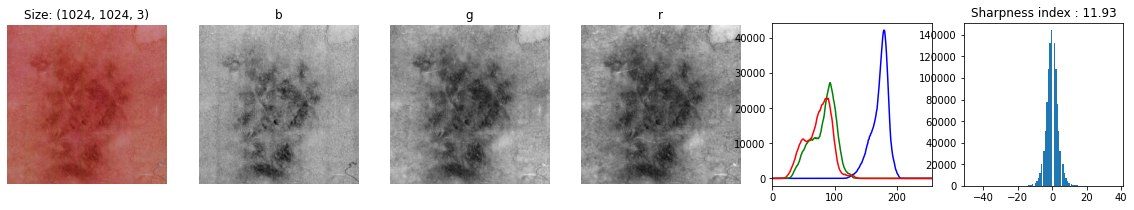

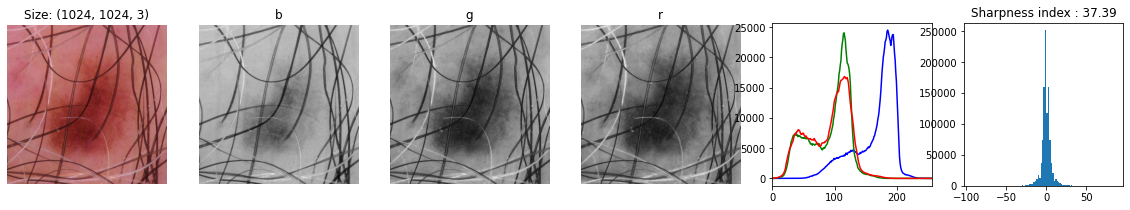

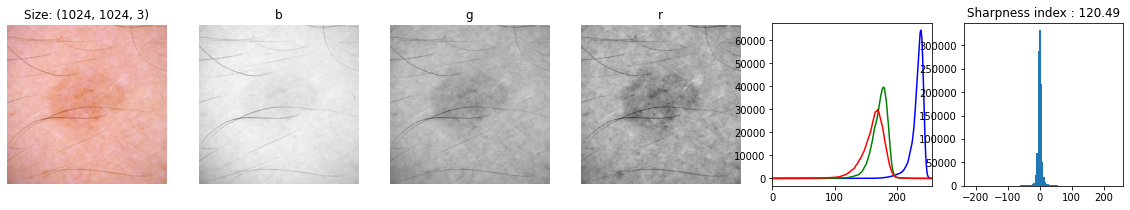

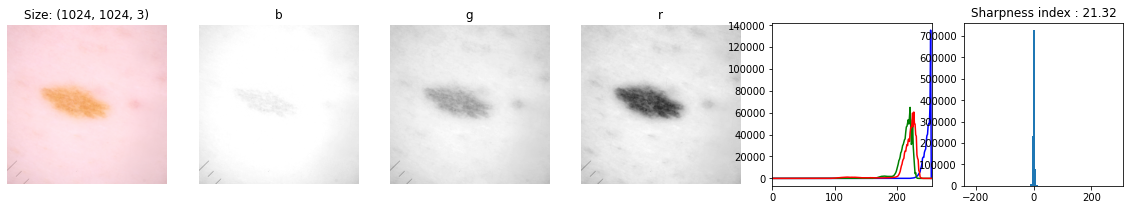

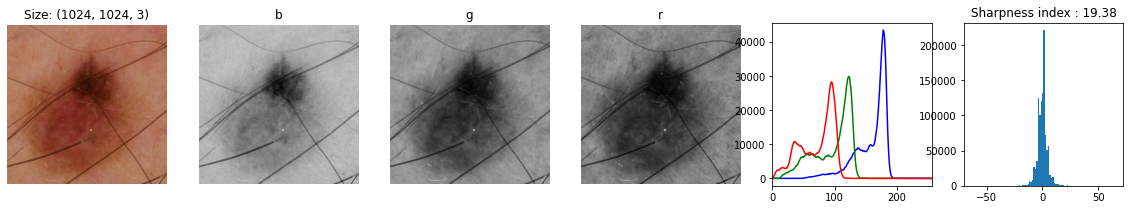

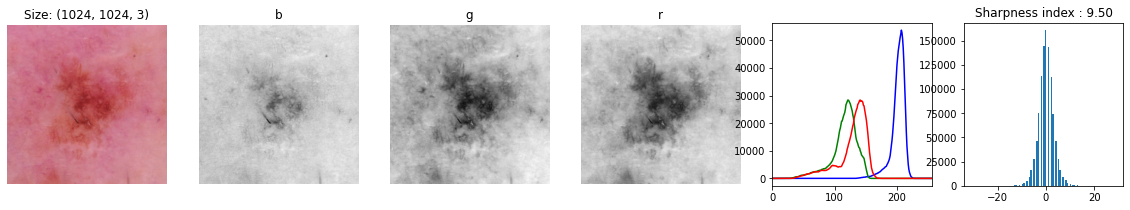

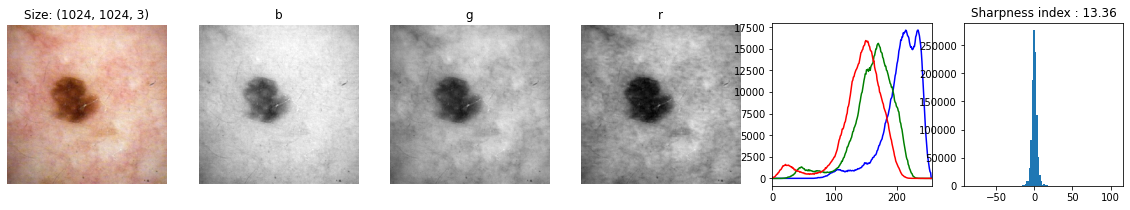

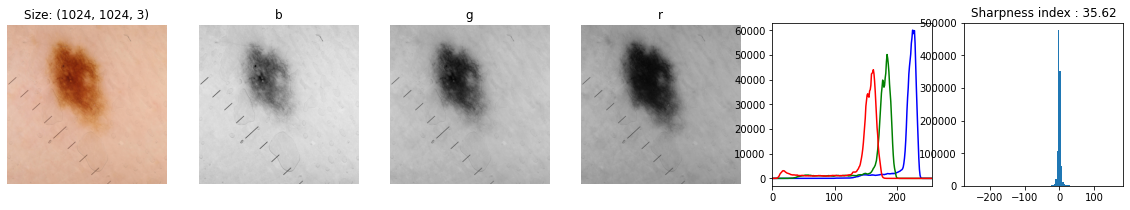

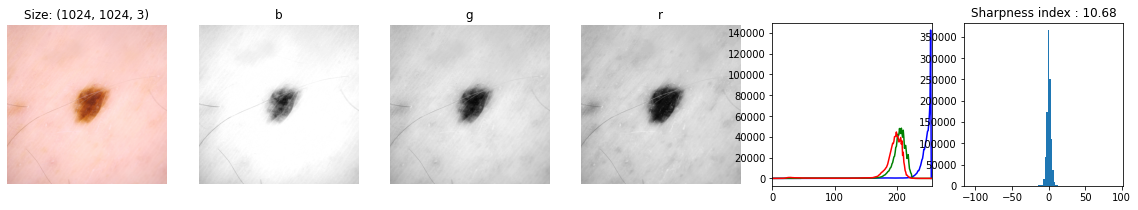

In [27]:
show9_RGB(random9_ben, 'Benign')

It seems we'll have a really difficult challenge to decide if an image is blurry using this approach with laplacian operator.

In [28]:
SI_org = []
SI_norm = []

for i in tqdm(range(train_df.shape[0])):
    img_name = os.path.join(img_dir, train_df.iloc[i].image_name+'.jpg')
    img_org = cv2.imread(img_name)
    img_norm = crop(img_name)
    gray_org = cv2.cvtColor(img_org, cv2.COLOR_BGR2GRAY)
    gray_norm = cv2.cvtColor(img_norm, cv2.COLOR_RGB2GRAY)
    lap_org = variance_of_laplacian(gray_org)
    SI_org.append(lap_org)
    lap_norm = variance_of_laplacian(gray_norm)
    SI_norm.append(lap_norm)
print(len(SI_org))    

100%|██████████| 33126/33126 [4:12:03<00:00,  2.19it/s]   

33126


Lets see this blur index distribution over all images in the train dataset.

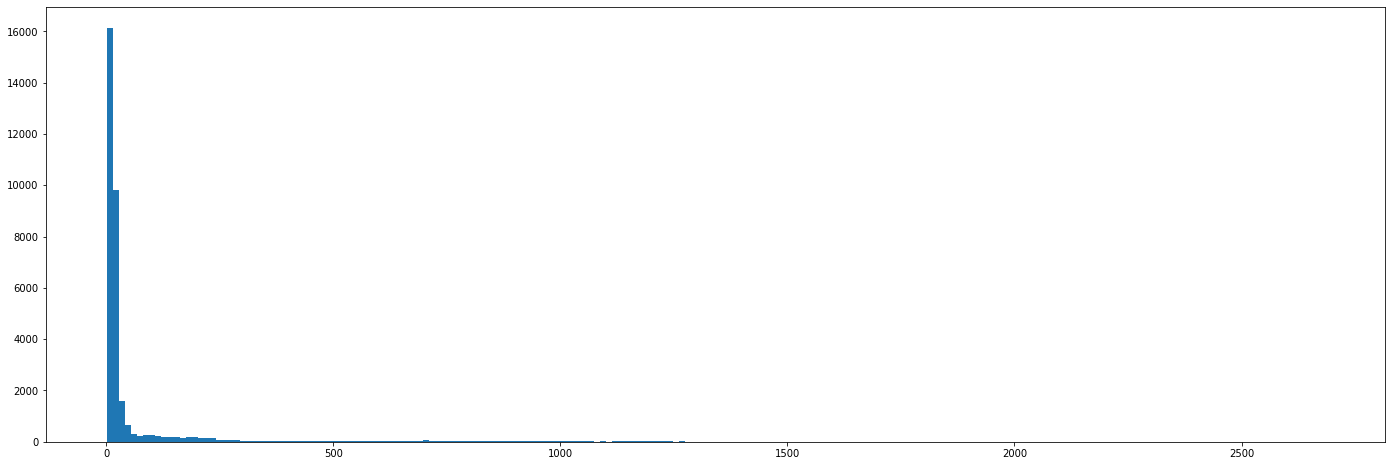

In [42]:
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(8)
plt.hist(SI_org, bins=200) #calculating histogram
plt.show()

As I suspected the absolute majority of the images has index below 25, which would implicate very blurry image if it was a regular photograph.

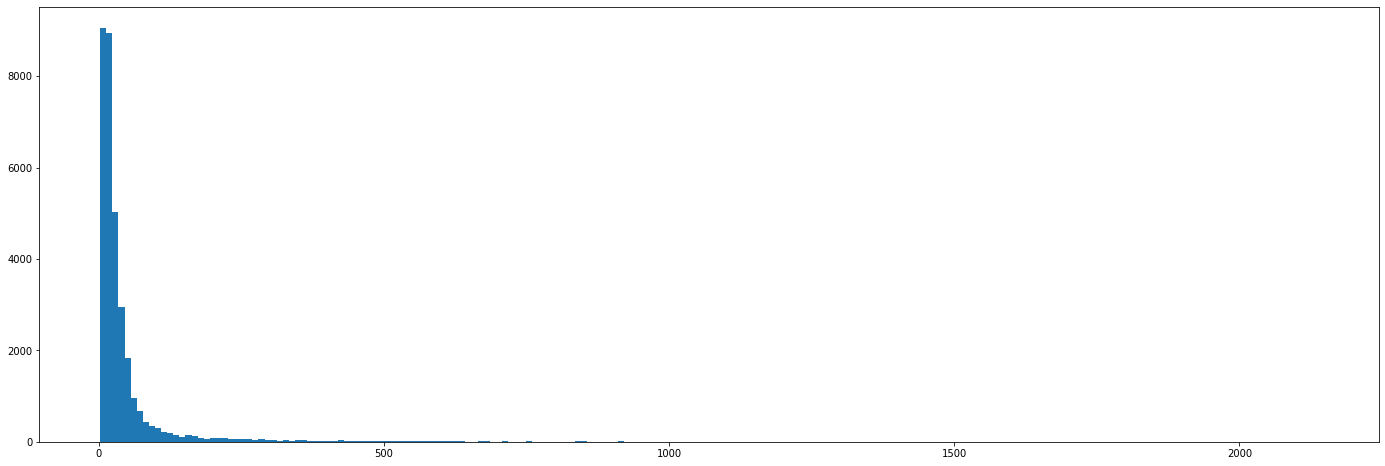

In [43]:
fig = plt.figure()
fig.set_figwidth(24)
fig.set_figheight(8)
plt.hist(SI_norm, bins=200) #calculating histogram
plt.show()

In [46]:
percs =[1, 2, 5, 15, 25, 35, 50, 65, 75, 85, 95, 99]
SI_org_arr = np.array(SI_org)
SI_org_percs = np.percentile(SI_org_arr, percs)
SI_norm_arr = np.array(SI_norm)
SI_norm_percs = np.percentile(SI_norm_arr, percs)

In [47]:
print('Sharpness Index for original images: ')
print(dict(zip([f'{str(x)}%' for x in percs], [f'{x:.1f}' for x in SI_org_percs])))
print('Sharpness Index for normalized images:')
print(dict(zip([f'{str(x)}%' for x in percs], [f'{x:.1f}' for x in SI_norm_percs])))

Sharpness Index for original images: 
{'1%': '3.3', '2%': '3.7', '5%': '4.5', '15%': '6.2', '25%': '7.9', '35%': '10.3', '50%': '14.6', '65%': '18.8', '75%': '24.2', '85%': '53.9', '95%': '382.1', '99%': '1092.7'}
Sharpness Index for normalized images:
{'1%': '6.7', '2%': '7.5', '5%': '8.8', '15%': '10.9', '25%': '13.0', '35%': '15.8', '50%': '22.1', '65%': '31.2', '75%': '40.9', '85%': '59.4', '95%': '173.0', '99%': '559.3'}
